# Whole CV

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Activation, Dense, LeakyReLU
from sklearn.model_selection import KFold

In [2]:
# Upload data

# FSCAV_data_train.xlsx is an excel file with different sheets. Each sheet correspond to a different IN VITRO experiments-train. Each sheet is 1100 x 60. It contains 
# 60 different currents profile (1100 samples) resulting from FSCAV. Each current profile has information about the concentration of serotonin.
# Within an experiments-train 15 FSCAV experiment are performed for 4 different concentration of serotonin (4x15 = 60) 

# Labels ( known concentration of serotonin ) are in the last sheet, already sorted 

dataset = pd.ExcelFile('FSCAV_data_train.xlsx')
sheets = dataset.sheet_names 
dataset = pd.read_excel('FSCAV_data_train.xlsx', sheet_name = None, header = None) # extract data

ds = dataset[sheets[0]] #initialize DataSet
for i in range(1,len(sheets)-1):  #the last one is the 'Labels' one
    ds = pd.concat([ds, dataset[sheets[i]]],1)
CVs = np.transpose(ds.values)
labels = np.array(dataset[sheets[len(sheets)-1]].values[:,2])

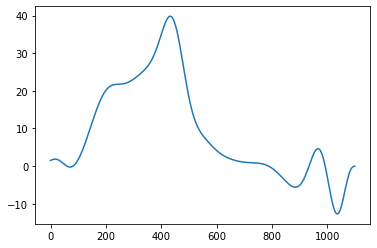

In [3]:
# Example of a current profile 
plt.plot(CVs[100])

In [4]:
# Building the datatset

dataset = np.zeros((len(labels), CVs.shape[1] + 1)) 
dataset[:,0:CVs.shape[1]] = CVs
dataset [:, CVs.shape[1]] = labels
dataset = pd.DataFrame(dataset)
dataset.info

<bound method DataFrame.info of           0         1         2         3         4         5         6     \
0    -0.025085 -0.039029 -0.053656 -0.068966 -0.084956 -0.101622 -0.118956   
1     0.071069  0.059592  0.047400  0.034494  0.020872  0.006537 -0.008509   
2     0.020276  0.006714 -0.007598 -0.022659 -0.038470 -0.055028 -0.072329   
3    -0.099964 -0.119903 -0.140668 -0.162254 -0.184653 -0.207855 -0.231848   
4     0.130477  0.120605  0.109956  0.098523  0.086300  0.073286  0.059477   
...        ...       ...       ...       ...       ...       ...       ...   
3814  0.725328  0.728384  0.730282  0.730993  0.730495  0.728763  0.725779   
3815  0.769828  0.772419  0.773764  0.773832  0.772600  0.770044  0.766145   
3816  0.727990  0.729949  0.730701  0.730219  0.728480  0.725463  0.721148   
3817  0.732712  0.734760  0.735579  0.735140  0.733417  0.730388  0.726032   
3818  0.737190  0.739158  0.739891  0.739359  0.737540  0.734409  0.729949   

          7         8         9

In [5]:
#Separate train and test, 80% and 20%. 
train_dataset = dataset.sample(frac=0.80, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [6]:
#Separate labels from input.

train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop(1100)
test_labels = test_features.pop(1100)

In [7]:
#Normalise the input, which could be of different orders of magnitude. 

normalizer = preprocessing.Normalization(input_shape=[1100,])
normalizer.adapt(np.array(train_features))

In [8]:
#Define the model. 
    
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.GaussianNoise(0.1),
        layers.Dense(1100, activation='relu'),  
        layers.Dropout(rate=0.2),
        layers.Dense(550, activation='selu'),
        layers.Dense(1)
    ])

   
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    return model
    

In [9]:
#Define a function to plot the loss per epoch 

def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Concentration]')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label="rmse")
    plt.plot(history.history['root_mean_squared_error'], label="rmse")
    plt.xlabel('Epoch')
    plt.ylabel('RMSE [Concentration]')

In [10]:
#Define a function to plot the prediction 

def plot_prediction(x, y):
    plt.scatter(train_features['Charge'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Charge')
    plt.ylabel('Concentration')
    plt.legend()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1100)              2201      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 1100)              0         
_________________________________________________________________
dense (Dense)                (None, 1100)              1211100   
_________________________________________________________________
dropout (Dropout)            (None, 1100)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 550)               605550    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 551       
Total params: 1,819,402
Trainable params: 1,817,201
Non-trainable params: 2,201
__________________________________________

<Figure size 432x288 with 0 Axes>

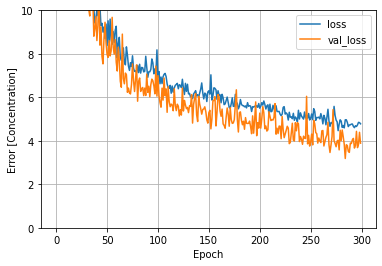

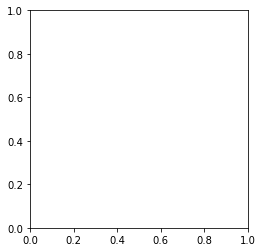

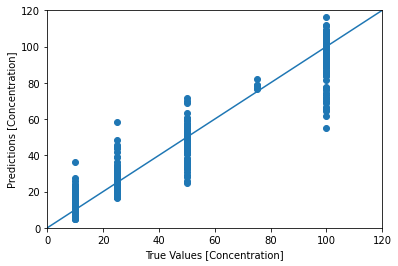

<Figure size 432x288 with 0 Axes>

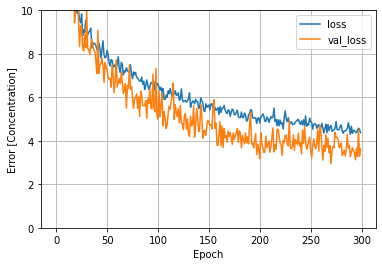

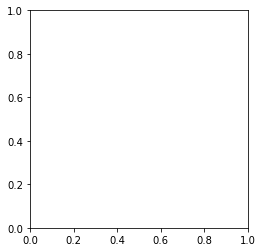

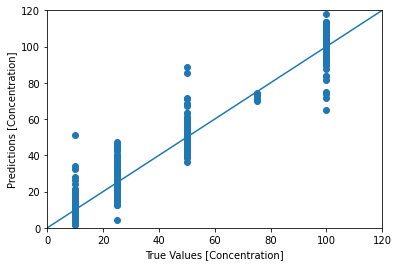

<Figure size 432x288 with 0 Axes>

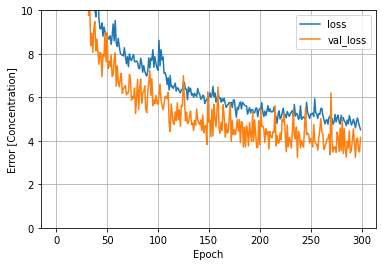

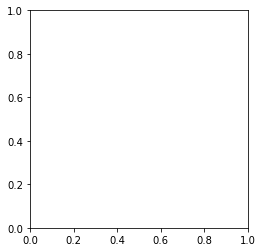

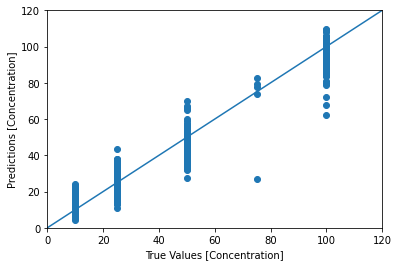

In [11]:
# Merge train and test 

inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels,test_labels), axis=0)

# Define the K-fold Cross Validator

num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation

fold_no = 1
for train, test in kfold.split(inputs, targets):
    dnn_fscav = build_and_compile_model(normalizer)
    dnn_fscav.summary()
    #Train the model
    history = dnn_fscav.fit( inputs[train], targets[train],validation_split=0.25,verbose=0, epochs=300)
    newfig = plt.figure()
    plot_loss(history)
    #Prediction of the validation dataset 
    test_predictions = dnn_fscav.predict(inputs[test]).flatten()

# Plotting
    a = plt.axes(aspect='equal')
    newfig2 = plt.figure()
    plt.scatter(targets[test], test_predictions)
    plt.xlabel('True Values [Concentration]')
    plt.ylabel('Predictions [Concentration]')
    lims = [0, 120]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    print('RMSE: ')
    print(math.sqrt(tf.keras.losses.MSE(test_predictions, targets[test])))
    fold_no = fold_no + 1

# Test on unknown data

In [50]:
#Upload test data 

dataset = pd.ExcelFile('FSCAV_data_test.xlsx')
sheets = dataset.sheet_names # I need to have sheet names
dataset = pd.read_excel('FSCAV_data_test.xlsx', sheet_name = None, header = None) # extract data

#Read all the sheets in the Excel file

ds = dataset[sheets[0]] #initialize DataSet
for i in range(1,len(sheets)-1):  #the last one is the 'Labels' one
    ds = pd.concat([ds, dataset[sheets[i]]],1)
CVs = np.transpose(ds.values)
labels = np.array(dataset[sheets[len(sheets)-1]].values[:,1])

# Normalize the inputs

traindata = np.array(train_features)
mean = traindata.mean()
sd = traindata.std()
CVs = (CVs - mean)/sd

# Dataframe of merged normalized sheets' data 

dataset = np.zeros((len(labels), CVs.shape[1] + 1)) 
dataset[:,0:CVs.shape[1]] = CVs
dataset [:, CVs.shape[1]] = labels
dataset = pd.DataFrame(dataset)
dataset.info

<bound method DataFrame.info of          0         1         2         3         4         5         6     \
0   -0.273281 -0.273337 -0.273392 -0.273445 -0.273497 -0.273545 -0.273590   
1   -0.272560 -0.272642 -0.272726 -0.272812 -0.272898 -0.272985 -0.273072   
2   -0.273450 -0.273575 -0.273701 -0.273830 -0.273959 -0.274090 -0.274220   
3   -0.271860 -0.271967 -0.272079 -0.272195 -0.272315 -0.272438 -0.272563   
4   -0.271354 -0.271478 -0.271609 -0.271746 -0.271888 -0.272035 -0.272186   
..        ...       ...       ...       ...       ...       ...       ...   
650 -0.234491 -0.236248 -0.238259 -0.240530 -0.243068 -0.245876 -0.248960   
651 -0.232910 -0.234674 -0.236700 -0.238995 -0.241564 -0.244412 -0.247546   
652 -0.232201 -0.234024 -0.236116 -0.238481 -0.241128 -0.244061 -0.247285   
653 -0.231406 -0.233203 -0.235270 -0.237613 -0.240240 -0.243154 -0.246363   
654 -0.231998 -0.233710 -0.235682 -0.237922 -0.240434 -0.243226 -0.246300   

         7         8         9     ...     

In [51]:
test_data_features = test_dataset.copy()
test_data_labels = test_data_features.pop(1100)

RMSE: 
5.363670961461289


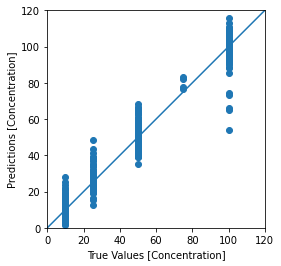

In [52]:
# Test on unknown data 
predictions = dnn_fscav.predict(test_data_features).flatten()
b = plt.axes(aspect='equal')
plt.scatter(test_data_labels, predictions)
plt.xlabel('True Values [Concentration]')
plt.ylabel('Predictions [Concentration]')
lims = [0, 120]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
print('RMSE: ')
print(math.sqrt(tf.keras.losses.MSE(predictions, test_data_labels)))

# Test on in vivo data

In [14]:
# Read control data

CVs_ctrl= np.zeros((83,1100))
for i in range(100,183):
    f=open('Invivo_CTRL_19-03-21/'+ str(i) + 'Ctrl_CV.txt' ,"r")
    lines=f.readlines()
    m = 0
    for x in lines:
        CVs_ctrl[i-100,m] = float(x.split('\t')[2])
        m = m+1
    f.close()
    
 # Read data after injection

CVs_DPH= np.zeros((33,1100))
for i in range(182,215):
    f=open('Invivo_DPH_19-03-21/' + str(i) + 'dph_CV.txt' ,"r")
    lines=f.readlines()
    m = 0
    for x in lines:
        CVs_DPH[i-182,m] = float(x.split('\t')[2])
        m = m+1
    f.close()

Text(0, 0.5, 'Predictions [Concentration]')

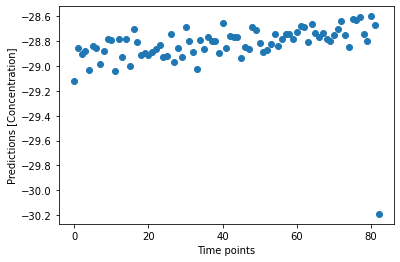

In [15]:
# Predict concentration of control using the NN

# Normalize the inputs

traindata = np.array(train_features)
mean = traindata.mean()
sd = traindata.std()
CVs_ctrl = (CVs_ctrl - mean)/sd

# Dataframe 

dataset = pd.DataFrame(CVs_ctrl)

# Predict

test_data_features_invivo = dataset.copy()
invivo_predictions = dnn_fscav.predict(test_data_features_invivo).flatten()
plt.scatter(np.arange(83),invivo_predictions)
plt.xlabel('Time points')
plt.ylabel('Predictions [Concentration]')

Text(0, 0.5, 'Predictions [Concentration]')

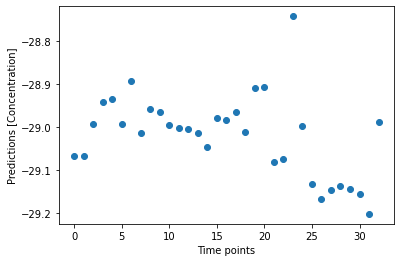

In [16]:
# Predict concentration after DPH injection using the NN

# Normalize the inputs

traindata = np.array(train_features)
mean = traindata.mean()
sd = traindata.std()
CVs_DPH = (CVs_DPH - mean)/sd

# Dataframe 

dataset = pd.DataFrame(CVs_DPH)

# Predict

test_data_features_invivo_drug = dataset.copy()
drug_invivo_predictions = dnn_fscav.predict(test_data_features_invivo_drug).flatten()
plt.scatter(np.arange(33),drug_invivo_predictions)
plt.xlabel('Time points')
plt.ylabel('Predictions [Concentration]')